# Neural and Evolutionary Learning - Final Project

## Notebook 2 - Problem Applications

## **2.2.** *Efficient Geometric Semantic Genetic Programming* - `Eff_GSGP`

|       Student Name      |    Student ID   |
|           ---           |       ---       |
|     Andriani Kakoulli   |     20230484    |
|       Susana Pires      |     20230540    |

### **1. Introduction**

> **CONTEXT** <br>

Data from Automatic Milking Systems (AMSs). <br>

Milk contents (fat, protein, lactose) are emasured at each milking event, to evaluate milk quality. This measurement is through a colourimetric mehtod that requires calibration every 2 weeks. <br>

> **GOAL** <br>

To infer the milk components - *Lactose* - from the other sensor data from the milking robots. <br>
Develop model to **predict** Lactose content.

> **GPOL**-based implementations

> **1.** **Search Space** definition <br>
> Python dictionary with following elements: <br>
> - *n_dims*, *function_set*, *constant_set*, *p_constants*  <br>
> - *max_init_depth*, *max_depth*, *n_batches*, *device*  <br>
> 
> **2.** **Problem Instance** definition  <br>
> Instantiantion of a SML (supervised-ML) object, it requires:  <br>
> - *fitness function*, *train data loader* <br>
> *number of jobs for parallel processing* (*Optional: can take test data loader object.*)  <br>
>
> **3.** **Algorithm** definition  <br>
> Instantiation of a Genetic Algorithm object, requires definitions of:  <br>
> - *problem instance*  <br>
> - *initialization methods*  <br>
> - *crossover operators*  <br>
> - *mutation operators*  <br>
> - *crossover probabilities*  <br>
> - *mutation probabilities*  <br>
> - *elitism*  <br>
> - *reproduction*  <br>
> - *device on evaluations will be processed*  <br>
> - *random seed*  <br>

### **2. Environment preparation**

#### **2.1. Imports**

In [1]:
import os
import csv
import copy
import json
import time
import math
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader

# algorithms
# GSGP instantiation
from gpolnel.algorithms.genetic_algorithm import GSGP, GeneticAlgorithm

# operators
#from gpolnel.operators.initializers import grow, ERC, Terminal, prm_grow
from gpolnel.operators.variators import prm_gs_xo, prm_gs_mtn, prm_efficient_gs_xo, prm_efficient_gs_mtn
from gpolnel.operators.selectors import prm_tournament
from gpolnel.operators.initializers_for_GP import grow, ERC, Terminal, prm_grow, full, prm_full

# problems
from gpolnel.problems.inductive_programming import SMLGS, SML

# utils
from gpolnel.utils.utils import train_test_split
from gpolnel.utils.ffunctions import Ffunctions
from gpolnel.utils.tree import Tree
from gpolnel.utils.inductive_programming import function_map, prm_reconstruct_tree, _get_tree_depth, _execute_tree
from gpolnel.utils.utils import load_cleaned_data
from gpolnel.utils.load_project_datasets import load_ams

#### **2.2. Global settings**

In [2]:
seed = 6

# Susana - my device will always be cpu because my pc doesn't have a NVIDIA (nor a recent AMD) GPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# RUN 1 - seed = 6
# RUN 2 - seed=8
# RUN 3 - seed=11
# RUN 4 - seed=12
# RUN 5 - seed=21
# RUN 6 - seed=27
# RUN 7 - seed=29
# RUN 8 - seed=33
# RUN 9 - seed=66
# RUN 10 - seed=91

#### **2.3. Data load**

To use the data loader<br>
- `load_ams` on file *load_datasets* on folder *utils*.

In [4]:
# Define parameters for the data usage
shuffle, p_test, p_val, n_batches_pct = True, .3, .3, 1

In [5]:
# AMS dataset
X, y = load_ams(X_y=True, device=device)

print(X.shape, y.shape)
print(X.device, y.device)

torch.Size([177, 14]) torch.Size([177])
cpu cpu


In [6]:
# print(X)
# print(y)

#### **2.4. Data split**

Since we are working with a very small dataset, the best decision for the split is by K-fold Cross Validation, but first we will use the Hold-Out Method. Then, after everything is running smoothly, we might adapt to Cross Validation.

Using indices for data split, because efficient GSGP doesn't use batch training in GPOL. <br>
Due to some incongruencies while testing cross validation and repeated iterations for the algorithms, our approach was: <br>
- Split the data into sets;
- Get the results (rmse);
- Change the random seed;
- Re-run the whole notebook (to guarantee the changes in split and randomness on the rest);
- Store the results for 10 runs for each combination of parameters;
- Discuss the results.

In [7]:
# Train and test sets
train_idx, test_idx = train_test_split(
    X=X, y=y, p_test=p_test, shuffle=shuffle, indices_only=True, seed=seed)

# Train and val sets
val_idx = train_idx[:int(train_idx.shape[0]*p_val)]
train_idx = train_idx[int(train_idx.shape[0]*p_val):]
total_batches = 1
batch_size = train_idx.shape[0]
print('Batch size: {}\nTotal batches: {}\n'.format(batch_size, total_batches))

print([train_idx.shape, val_idx.shape, test_idx.shape])

print(f'Train:\t{train_idx.shape[0]}\nVal:\t{val_idx.shape[0]}\nTest:\t{test_idx.shape[0]}')
print('Total:\t{}'.format(train_idx.shape[0] + val_idx.shape[0] + test_idx.shape[0]))

Batch size: 87
Total batches: 1

[torch.Size([87]), torch.Size([37]), torch.Size([53])]
Train:	87
Val:	37
Test:	53
Total:	177


### **3. Approach**

#### **3.1. Search Space Definition**

In [8]:
# functional set
fset = [function_map['add'], function_map['sub'], function_map['mul'], function_map['div'], function_map['exp'],
            function_map['log']]

# search space
sspace_sml_gs = {
    'n_dims': X.shape[1],
    'function_set': fset,
    'constant_set': ERC(-1., 1.),
    'p_constants': 0.1, # probability of using a constant = 10% , bcs the features will be more informative
    'max_init_depth': 3,
    'device': device}

#### **3.2. SML Problem Instance**

In [9]:
# Uses the dataset instead of torch DataLoaders
pi_sml_gs = SMLGS(
    sspace=sspace_sml_gs,
    # def of fitness function (rmse: decrese the error as it's a regression prediction problem)
    # we can use another fitness function - decision is problem dependent
    ffunction=Ffunctions('rmse'),
    X=X, y=y,
    train_indices=train_idx,
    test_indices=val_idx)       # changed to validation because we need test_idx at the end

#### **3.3. Algorithm instantiation**

##### GSM Steps

* `ms`:<br>
*A 1D tensor of length m.* <br> 
*If it is a single-valued tensor, then the mutation step equals ms;* <br>
*If it is a _1D tensor of length m_, then the mutation step is selected from it at random, at each call of gs_mnt.*

In [10]:
# Define GSM (geometric semantic mutation) steps 
to, by = 5.0, 0.25
ms = torch.arange(by, to + by, by, device=device)
print(ms)

tensor([0.2500, 0.5000, 0.7500, 1.0000, 1.2500, 1.5000, 1.7500, 2.0000, 2.2500,
        2.5000, 2.7500, 3.0000, 3.2500, 3.5000, 3.7500, 4.0000, 4.2500, 4.5000,
        4.7500, 5.0000])


##### Log properties

Setting up log properties, because when reconstructing the tree, we need the paths for persisting objects.

In [11]:
# Setup logging properties
file_dir = './log/'
file_name = 'eff_gsgp_project_test.log'
log_path = file_dir + file_name

# If GSGP solution should be reconstructed, the paths for persisting 
# the needed objects should be set.
path_rts = os.path.join(file_dir, 'reconstruct', 'rts')
path_init_pop = os.path.join(file_dir, 'reconstruct', 'init_pop')

if os.path.exists(file_dir + file_name):
    os.remove(file_dir + file_name)
if not os.path.exists(file_dir):
    os.makedirs(file_dir)

for path_i in [file_dir, path_init_pop, path_rts]:
    if not os.path.exists(path_i):
        os.makedirs(path_i)

print([log_path, path_rts, path_init_pop])

['./log/eff_gsgp_project_test.log', './log/reconstruct\\rts', './log/reconstruct\\init_pop']


##### **Algorithm Definition**

In [12]:
# Check how different values affect the performance
ps = 100                                                                              # ps = 10  //  100
selection_pressure = .07
mutation_prob = 0.1
xo_prob = 0.9
has_elitism = True                                                                     # True  //  False 
allow_reproduction = False

mheuristic = GSGP(
    pi=pi_sml_gs,
    
    # If individuals should be reconstructed, it must be defined before fitting the algorithm.
    # Defined on cell above
    path_init_pop=path_init_pop, 
    path_rts=path_rts, 
    
    # Initializer - it can be the same tree initializer as traditional GP.              # grow  //  full
    initializer=grow,
    
    # Selector - it can be the same GP selector as tradicional GP.
    selector=prm_tournament(pressure=selection_pressure),
    
    # Other Algorithm hyperparameters
    pop_size=ps,
    p_m=mutation_prob,
    p_c=xo_prob,
    elitism=has_elitism,
    reproduction=allow_reproduction,  # False = or xo or mutation
    device=device,
    seed=seed,
    
    # Efficient Crossover
    crossover=prm_efficient_gs_xo(X, prm_grow(sspace=pi_sml_gs.sspace)),                # prm_grow  //  prm_full
    
    # Efficient Mutation
    mutator=prm_efficient_gs_mtn(X, prm_grow(sspace=pi_sml_gs.sspace), ms))             # prm_grow  //  prm_full

##### GSGP Initialization

In [13]:
mheuristic._initialize()

In [14]:
mheuristic.best_sol.fit

tensor(0.8970)

In [15]:
mheuristic.best_sol.repr_

tensor([6.0259, 5.8777, 5.7526, 5.8916, 6.0568, 5.8833, 5.7683, 5.8171, 5.9216,
        5.6971, 5.6204, 5.8944, 5.6836, 5.6630, 5.9108, 5.7589, 5.5215, 5.6595,
        5.9162, 5.7683, 5.8230, 5.8289, 5.7301, 5.9506, 5.9738, 5.9189, 5.6525,
        5.7004, 5.6525, 5.6937, 5.8201, 5.6276, 5.8889, 5.9636, 5.6768, 5.7714,
        5.6454, 5.7961, 5.6348, 5.6971, 5.7961, 6.3801, 5.7268, 5.7589, 5.6870,
        5.7268, 5.7462, 5.6870, 5.9108, 5.6525, 5.8665, 5.8999, 5.8749, 5.6525,
        5.6904, 5.6490, 5.7137, 5.7526, 6.0186, 5.8493, 5.7526, 5.7038, 5.8889,
        6.0234, 5.6560, 5.7494, 5.6904, 5.5607, 5.7589, 5.6348, 5.7203, 5.7268,
        5.7104, 5.8636, 5.6560, 6.0684, 5.9789, 5.6904, 5.8636, 5.7268, 5.6560,
        5.8141, 5.8435, 5.7462, 5.7526, 5.9322, 5.9865, 5.6384, 5.7714, 5.6630,
        5.7301, 5.6595, 5.9713, 5.6595, 5.6802, 5.8081, 5.6630, 5.7170, 5.8493,
        5.8464, 5.8944, 5.7398, 5.6525, 5.7526, 5.7398, 5.6904, 5.7900, 5.7557,
        5.7746, 5.7838, 5.7004, 6.0210, 

##### **Solve**

In [16]:
mheuristic.solve(n_iter=100,
                tol=0.001,
                test_elite=True, 
                verbose=3,
                log=2,
                log_path=log_path)

print(' '*100)
print('Best solution RMSE fitness: {:.2f} train, {:.2f} val.\n'.format(mheuristic.best_sol.fit.item(), mheuristic.best_sol.test_fit.item()))

-------------------------------------------------------------------------------------------------------
           |                    Best solution                      |            Population            |
-------------------------------------------------------------------------------------------------------
Generation | Depth    Fitness          Test Fitness         Timing | AVG Fitness           STD Fitness
-------------------------------------------------------------------------------------------------------
0          | 1        0.7191           0.734892              0.161 | 5854.08                   22522.6
1          | 4        0.622362         0.650444              0.121 | 2.98773                   1.53825
2          | 7        0.554691         0.593018              0.127 | 1.13991                  0.592025
3          | 8        0.436017         0.362574              0.130 | 0.921798                 0.786015
4          | 12       0.223167         0.235637              0.156 | 

##### Reconstruction

In [17]:
# mheuristic.best_sol.repr_
# mheuristic._set_best_sol()

In [18]:
# Persists evolution history for reconsctruction
# Change name when final run for project
mheuristic.write_history(file_dir + 'GSGP_history_trials_tt.csv')

In [19]:
# Read evolution history for reconstruction
hist_eff_gsgp = pd.read_csv(file_dir + 'GSGP_history_trials_tt.csv', index_col=0)
hist_eff_gsgp

,Iter,Operator,T1,T2,Tr,ms,Fitness
6_1_o1_xo_1,1,crossover,6_0_30,6_0_4,6_1_rt_xo_0,-1.00,3.197184
6_1_o2_xo_2,1,crossover,6_0_4,6_0_30,6_1_rt_xo_0,-1.00,3.874575
6_1_o1_xo_4,1,crossover,6_0_88,6_0_52,6_1_rt_xo_3,-1.00,4.815236
6_1_o2_xo_5,1,crossover,6_0_52,6_0_88,6_1_rt_xo_3,-1.00,1.150961
6_1_o1_xo_7,1,crossover,6_0_2,6_0_22,6_1_rt_xo_6,-1.00,4.229680
...,...,...,...,...,...,...,...
6_14_o2_xo_2172,14,crossover,6_13_o1_xo_2010,6_13_o1_xo_2022,6_14_rt_xo_2170,-1.00,0.203006
6_14_o1_mtn_2174,14,mutation,6_13_o1_xo_1965,-1.0,6_14_rt_mtn_2173,2.75,1.221659
6_14_o1_mtn_2176,14,mutation,6_13_o1_xo_2022,-1.0,6_14_rt_mtn_2175,5.00,5.009321
6_14_o1_xo_2178,14,crossover,6_13_o1_xo_1881,6_13_o2_xo_1911,6_14_rt_xo_2177,-1.00,0.202997


In [20]:
# reconstructor = prm_reconstruct_tree(hist_eff_gsgp, path_init_pop=path_init_pop, path_rts=path_rts, device='cpu')
# repr_ = reconstructor(hist_eff_gsgp['Fitness'].idxmin())

# len(repr_)

**Dictionary for the features:** <br>
lactation: 'lct' <br>
delivery_age_years: 'dlv_ay' <br>
'dim' <br>
dry_days: 'dd' <br>
forage_kg_day: 'fkd' <br>
rumination_min_day: 'rmd' <br>
milk_kg_day: 'mkd' <br>
milk_kg_min_robot: 'mkmr' <br>
milkings_day: 'md' <br>
errors_by_100_milkings: 'er_100m' <br>
high_cdt_by_100_milkings: 'hcdt_100m' <br>
watery_by_100_milkings: 'w100m' <br>
refusals_by_milking: 'ref_bm' <br>
colostrum_separated_kg: 'cskg' <br>

'lct', 'dlv_ay', 'dim', 'dd', 'fkd', 'rmd', 'mkd', 'mkmr', 'md', 'er_100m', 'hcdt_100m', 'w100m', ref_bm', 'cskg'

In [21]:
# data_fts = ['lct', 'dlv_ay', 'dim', 'dd', 'fkd', 'rmd', 'mkd', 'mkmr', 'md', 'er_100m', 'hcdt_100m', 'w100m', 'ref_bm', 'cskg']

# t = Tree(repr_= repr_)

# t.printTree()

# print('-'*100)

# t.printTree(feature_names=data_fts)

##### GP Evolution

In [22]:
# Open log file
rows = []
with open(log_path, 'r') as file:
    # Create a CSV reader object
    csv_reader = csv.reader(file)
    # Iterate over each row in the CSV file
    for row in csv_reader:
        # Process each row (each row is a list of values)
        rows.append(row)

# Fitness history
history_fits = [float(row[7].split('(')[1].split(')')[0]) for row in rows]

# Test fitness history
history_val_fits = [float(row[7].split('(')[1].split(')')[0]) for row in rows]

# Solution size history
#history_sizes = [float(row[6].split('(')[1].split(')')[0]) for row in rows]

# Runtime
#history_timing = [float(row[5]) for row in rows]

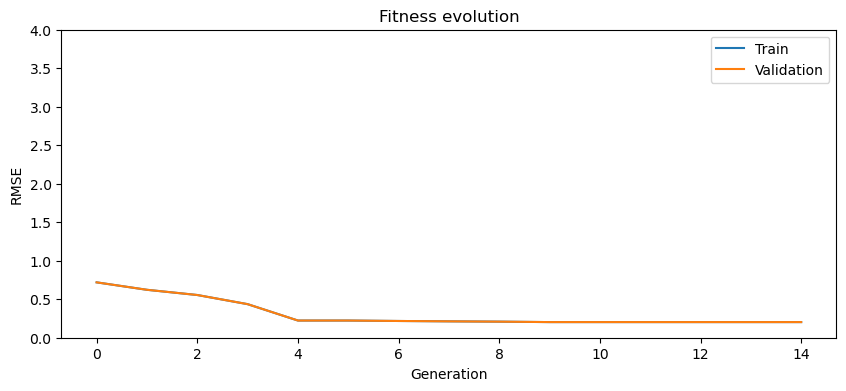

Best solution RMSE fitness: 0.20 train, 0.22 test.



In [23]:
plt.figure(figsize=(10, 4))

plt.plot(history_fits, label='Train')
plt.plot(history_val_fits, label='Validation')
plt.title('Fitness evolution')
plt.xlabel('Generation')
plt.ylabel('RMSE')
plt.ylim(bottom=0, top=4)
plt.legend()
plt.show()

print('Best solution RMSE fitness: {:.2f} train, {:.2f} test.\n'.format(mheuristic.best_sol.fit.item(), mheuristic.best_sol.test_fit.item()))

### **4. Results - Test**

##### **Processing**

In [24]:
# Evaluate the final solution
best_individual = mheuristic.best_sol
best_solution = best_individual.repr_

In [25]:
y_pred = _execute_tree(best_solution, X=test_idx)

In [26]:
y_test = y[test_idx]

In [27]:
import warnings
warnings.filterwarnings("ignore")

##### **Results**

In [28]:
# Compute the final performance on the test set
final_rmse = torch.sqrt(torch.mean((y_pred - torch.tensor(y_test, dtype=torch.float32).to(device)) ** 2)).item()

print(f'Final RMSE on test set: {final_rmse}')

Final RMSE on test set: 0.17301790416240692


In [29]:
# manually insterting RMSE of each run and each combination
combinations = {
    'grow | ps=10 | elitism=True': [0.7172418236732483,  0.9725918769836426, 1.0783541202545166, 4.8746514320373535, 1.7763582468032837, 
                                    2.2134861946105957, 0.09376145154237747, 0.4006068706512451, 0.5184093117713928, 1.2960807085037231],
    'grow | ps=10 | elitism=False': [1.8821302652359009, 4.773576259613037, 2187.522705078125, 108.17161560058594, 32.438011169433594,
                                     3.5534491539001465, 4.3327813148498535, 2.924149990081787, 5.549167156219482, 3.377030611038208],

    'grow | ps=100 | elitism=True': [0.17301790416240692, 0.08542505651712418, 0.0942370668053627, 0.10797682404518127, 0.08322376757860184, 
                                     0.06670843064785004, 0.19457924365997314, 0.07861793041229248, 0.14319069683551788, 0.09115146845579147],
    'grow | ps=100 | elitism=False': [0.17297174036502838, 0.08542505651712418, 0.09707684814929962, 0.11079820245504379, 0.08555017411708832,
                                      0.06670843064785004, 0.19457924365997314, 0.07164227217435837, 0.14319069683551788, 0.06163724139332771],

    'full | ps=10 | elitism=True': [0.9844868779182434, 4.345547676086426, 1.2121964693069458, 3.1090166568756104, 1.2017873525619507,
                                    1.872469186782837, 1.148478627204895, 3.889319896697998, 0.4164426028728485, 0.9952272772789001],
    'full | ps=10 | elitism=False': [0.45188668370246887, 29277.69921875, 38.0218505859375, 471647.34375, 2.9635369777679443,
                                     14.001502990722656, 1.148478627204895, 9.127652168273926, 2372.386474609375, 19.7196044921875],
    
    'full | ps=100 | elitism=True': [0.10877299308776855, 0.27158159017562866, 0.08424984663724899, 0.08411453664302826, 0.26001667976379395,
                                     0.2859433889389038, 0.21521228551864624, 0.14878833293914795, 0.0640425980091095, 0.3307787775993347],
    'full | ps=100 | elitism=False': [0.1306624561548233, 0.27158159017562866, 0.11043307185173035, 0.0930304229259491, 0.26001667976379395,
                                      0.2859433889389038, 0.21521228551864624, 0.14878833293914795, 0.0640425980091095, 0.062049876898527145]}

df_combo = pd.DataFrame(combinations).T
df_combo

,0,1,2,3,4,5,6,7,8,9
grow | ps=10 | elitism=True,0.717242,0.972592,1.078354,4.874651,1.776358,2.213486,0.093761,0.400607,0.518409,1.296081
grow | ps=10 | elitism=False,1.882130,4.773576,2187.522705,108.171616,32.438011,3.553449,4.332781,2.924150,5.549167,3.377031
grow | ps=100 | elitism=True,0.173018,0.085425,0.094237,0.107977,0.083224,0.066708,0.194579,0.078618,0.143191,0.091151
grow | ps=100 | elitism=False,0.172972,0.085425,0.097077,0.110798,0.085550,0.066708,0.194579,0.071642,0.143191,0.061637
full | ps=10 | elitism=True,0.984487,4.345548,1.212196,3.109017,1.201787,1.872469,1.148479,3.889320,0.416443,0.995227
full | ps=10 | elitism=False,0.451887,29277.699219,38.021851,471647.343750,2.963537,14.001503,1.148479,9.127652,2372.386475,19.719604
full | ps=100 | elitism=True,0.108773,0.271582,0.084250,0.084115,0.260017,0.285943,0.215212,0.148788,0.064043,0.330779
full | ps=100 | elitism=False,0.130662,0.271582,0.110433,0.093030,0.260017,0.285943,0.215212,0.148788,0.064043,0.062050


In [30]:
# ATTENTION - If we repeat the same run it will create new columns here.
# add the 'Runs' as columns
df_combo.columns = [f'Run_{i+1}' for i in range(len(df_combo.columns))]
df_combo.rename(columns={'index': 'Runs'}, inplace=True)

# display the updated df
df_combo.round(3)

,Run_1,Run_2,Run_3,Run_4,Run_5,Run_6,Run_7,Run_8,Run_9,Run_10
grow | ps=10 | elitism=True,0.717,0.973,1.078,4.875,1.776,2.213,0.094,0.401,0.518,1.296
grow | ps=10 | elitism=False,1.882,4.774,2187.523,108.172,32.438,3.553,4.333,2.924,5.549,3.377
grow | ps=100 | elitism=True,0.173,0.085,0.094,0.108,0.083,0.067,0.195,0.079,0.143,0.091
grow | ps=100 | elitism=False,0.173,0.085,0.097,0.111,0.086,0.067,0.195,0.072,0.143,0.062
full | ps=10 | elitism=True,0.984,4.346,1.212,3.109,1.202,1.872,1.148,3.889,0.416,0.995
full | ps=10 | elitism=False,0.452,29277.699,38.022,471647.344,2.964,14.002,1.148,9.128,2372.386,19.720
full | ps=100 | elitism=True,0.109,0.272,0.084,0.084,0.260,0.286,0.215,0.149,0.064,0.331
full | ps=100 | elitism=False,0.131,0.272,0.110,0.093,0.260,0.286,0.215,0.149,0.064,0.062


##### **Median and Average RMSE per combination.**

In [31]:
# calculate the median and mean for each row (excluding the first column)
medians = df_combo.iloc[:, 1:].median(axis=1)
avg = df_combo.iloc[:, 1:].mean(axis=1)

# Add the median values as a new column named 'Median RMSE'
df_combo['Median RMSE'] = medians
df_combo['Avg RMSE'] = avg

# Display the updated DataFrame
df_combo

,Run_1,Run_2,Run_3,Run_4,Run_5,Run_6,Run_7,Run_8,Run_9,Run_10,Median RMSE,Avg RMSE
grow | ps=10 | elitism=True,0.717242,0.972592,1.078354,4.874651,1.776358,2.213486,0.093761,0.400607,0.518409,1.296081,1.078354,1.469367
grow | ps=10 | elitism=False,1.882130,4.773576,2187.522705,108.171616,32.438011,3.553449,4.332781,2.924150,5.549167,3.377031,4.773576,261.404721
grow | ps=100 | elitism=True,0.173018,0.085425,0.094237,0.107977,0.083224,0.066708,0.194579,0.078618,0.143191,0.091151,0.091151,0.105012
grow | ps=100 | elitism=False,0.172972,0.085425,0.097077,0.110798,0.085550,0.066708,0.194579,0.071642,0.143191,0.061637,0.085550,0.101845
full | ps=10 | elitism=True,0.984487,4.345548,1.212196,3.109017,1.201787,1.872469,1.148479,3.889320,0.416443,0.995227,1.212196,2.021165
full | ps=10 | elitism=False,0.451887,29277.699219,38.021851,471647.343750,2.963537,14.001503,1.148479,9.127652,2372.386475,19.719604,19.719604,55931.379119
full | ps=100 | elitism=True,0.108773,0.271582,0.084250,0.084115,0.260017,0.285943,0.215212,0.148788,0.064043,0.330779,0.215212,0.193859
full | ps=100 | elitism=False,0.130662,0.271582,0.110433,0.093030,0.260017,0.285943,0.215212,0.148788,0.064043,0.062050,0.148788,0.167900


> **Best median RMSE on test set: 0.085550** <br>
>
> Achieved with the combination of *initializer=grow*, *ps=100*, *elitism=False*